In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import pickle
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from utils_cube import plot_daily_wx
from shapely.ops import cascaded_union

## Merge storm with the same time stamps

In [3]:
with open('../../DATA/NCWF/processed_bundle/storm_bundle.pkl', 'rb') as pfile:
    wx_bundle, alt_bundle, st_bundle = pickle.load(pfile)
    
with open('../../DATA/NCWF/storm_20131221.pkl', 'rb') as pfile:
    wx_single, alt_single, st_single = pickle.load(pfile)

In [57]:
st_holder = []
alt_holder = []
wx_holder = []
for i in range(len(wx_bundle)):
    if st_bundle[i] not in st_holder:
        st_holder.append(st_bundle[i])
        alt_holder.append(alt_bundle[i])
        wx_holder.append(wx_bundle[i])
    else:
        idx = st_holder.index(st_bundle[i])
        alt_holder[idx] = np.concatenate((alt_holder[idx], alt_bundle[i]))
        wx_holder[idx] = wx_holder[idx] + wx_bundle[i]
        
        unique_FL = pd.unique(alt_holder[idx])
        
        alts_idx = []
        for ele in unique_FL:
            alts_idx.append(np.where(alt_holder[idx] == ele)[0])
        alt_holder[idx] = unique_FL
        
        tmp_polys = []
        for ele in alts_idx:
            tmp_polys.append(cascaded_union([wx_holder[idx][element] for element in ele])) 
        wx_holder[idx] = tmp_polys

In [58]:
with open('../../DATA/NCWF/processed_bundle/storm_bundle_merge.pkl', 'wb') as psfile:
    pickle.dump((wx_holder, alt_holder, st_holder), psfile)
# with open('NCWF/ProcessedNCFW_bundle/detect_bundle.pkl', 'wb') as pdfile:
#     pickle.dump((d_polys, d_alts, d_times), pdfile)

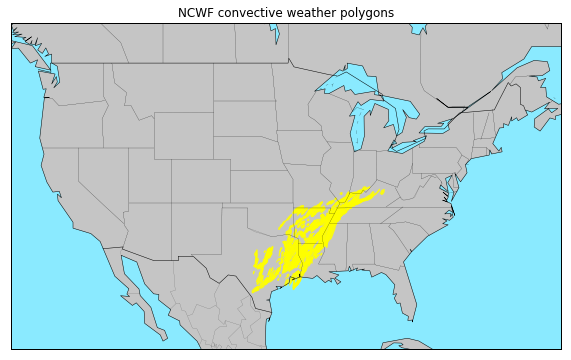

In [4]:
bad_poly = plot_daily_wx(wx_single)

## Convert geom to pixels

In [180]:
from shapely.geometry import MultiPoint, Polygon, Point
from matplotlib import path

In [4]:
grbs_common_info = np.load('/media/storage/DATA/filtered_weather_data/grbs_common_info.npz')
basegrid_lat = grbs_common_info['basegrid_lat']
basegrid_lon = grbs_common_info['basegrid_lon']
basegrid = grbs_common_info['basegrid']
smallgrid = grbs_common_info['smallgrid']

In [3]:
with open('../../DATA/NCWF/processed_bundle/storm_bundle_merge.pkl', 'rb') as psfile:
    wx_holder, alt_holder, st_holder = pickle.load(psfile)

In [145]:
st_holder = np.array(st_holder)
n_poly = 0
all_alt = []
for i in range(len(st_holder)):
    for j in range(len(alt_holder[i])):
        n_poly += 1
        tmp_alt = alt_holder[i][j]
        all_alt.append(tmp_alt)
all_alt = np.array(all_alt)
unique_alt = np.sort(np.unique(all_alt))

alt_dict = {}
j = 0
for lvl in unique_alt:
    alt_dict[lvl] = j
    j += 1

In [279]:
ncwf_arr = np.zeros(shape = (st_holder.shape[0], unique_alt.shape[0], smallgrid.shape[0]), dtype = np.int8)
for i in range(st_holder.shape[0]):
    if i % 500 == 0:
        print(i)
    for j in range(len(alt_holder[i])):
        tmp_wx = wx_holder[i][j]
        tmp_alt = alt_holder[i][j]
        bbox = tmp_wx.bounds
        tmp_idx = (smallgrid[:, 0] >= bbox[0]) & \
                    (smallgrid[:, 1] >= bbox[1]) & \
                        (smallgrid[:, 0] <= bbox[2]) & \
                            (smallgrid[:, 1] <= bbox[3])
        if tmp_wx.geom_type == 'MultiPolygon':
            for poly in tmp_wx:
                p = path.Path(poly.exterior)
                searched_idx = p.contains_points(smallgrid[tmp_idx])
                ncwf_arr[i, alt_dict[tmp_alt], np.where(tmp_idx)[0][searched_idx]] = 1
        else:
            p = path.Path(tmp_wx.exterior)
            searched_idx = p.contains_points(smallgrid[tmp_idx])
            ncwf_arr[i, alt_dict[tmp_alt], np.where(tmp_idx)[0][searched_idx]] = 1

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


In [291]:
np.savez_compressed('../../DATA/NCWF/gridded_storm.npz', 
                    ncwf_arr = ncwf_arr, 
                    start_time = st_holder,
                    unique_alt = unique_alt,
                    smallgrid = smallgrid)
with open('../../DATA/NCWF/alt_dict.pkl', 'wb') as pfile:
    pickle.dump(alt_dict, pfile)

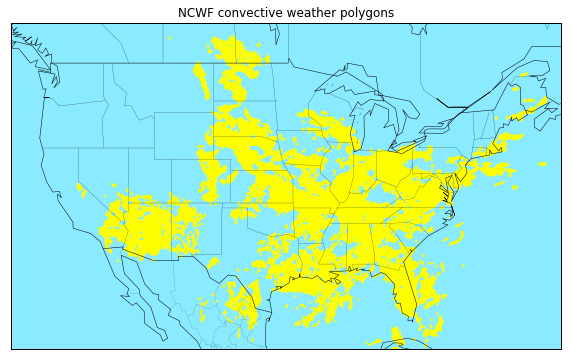

In [293]:
bad_poly = plot_daily_wx(wx_holder[3280:3320])

In [281]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline

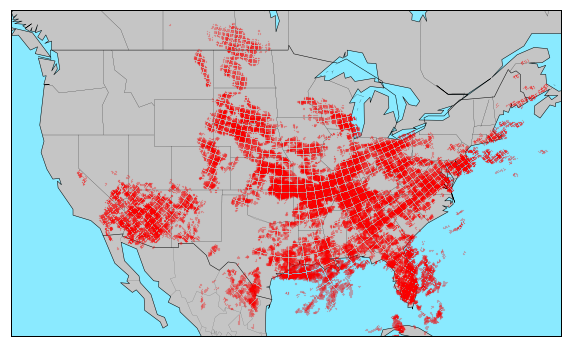

In [292]:
plt.figure(figsize=(10,6))
m = Basemap(llcrnrlon = -128,llcrnrlat = 22.,urcrnrlon = -63,urcrnrlat = 52,projection='merc')
m.drawmapboundary(fill_color='#8aeaff')
m.fillcontinents(color='#c5c5c5', lake_color='#8aeaff')
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.5)
m.drawstates(linewidth=0.1)

draw_idx = np.where(ncwf_arr[3280:3320, :, :] == 1)
draw_pnt = []

for idx in draw_idx[-1]:
    draw_pnt.append(smallgrid[idx])
    
draw_pnt = np.array(draw_pnt)
x, y = m(draw_pnt[:, 0], draw_pnt[:, 1])

plt.plot(x, y, 'ro',ms = 0.1)

In [298]:
ncwf_arr.shape

(5974, 13, 138934)